# Task 2 Notebook

### Data Exploration
- Much of the data exploration that was conducted was important for both models and was redundant here. See Task 1 notebook for all  initial data exploration.

In [1]:
# imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [67]:
# data handling and visualization package
import exp
# loading all storm data to a data frame so that we can inspect it
data_df = exp.load_data_to_df()

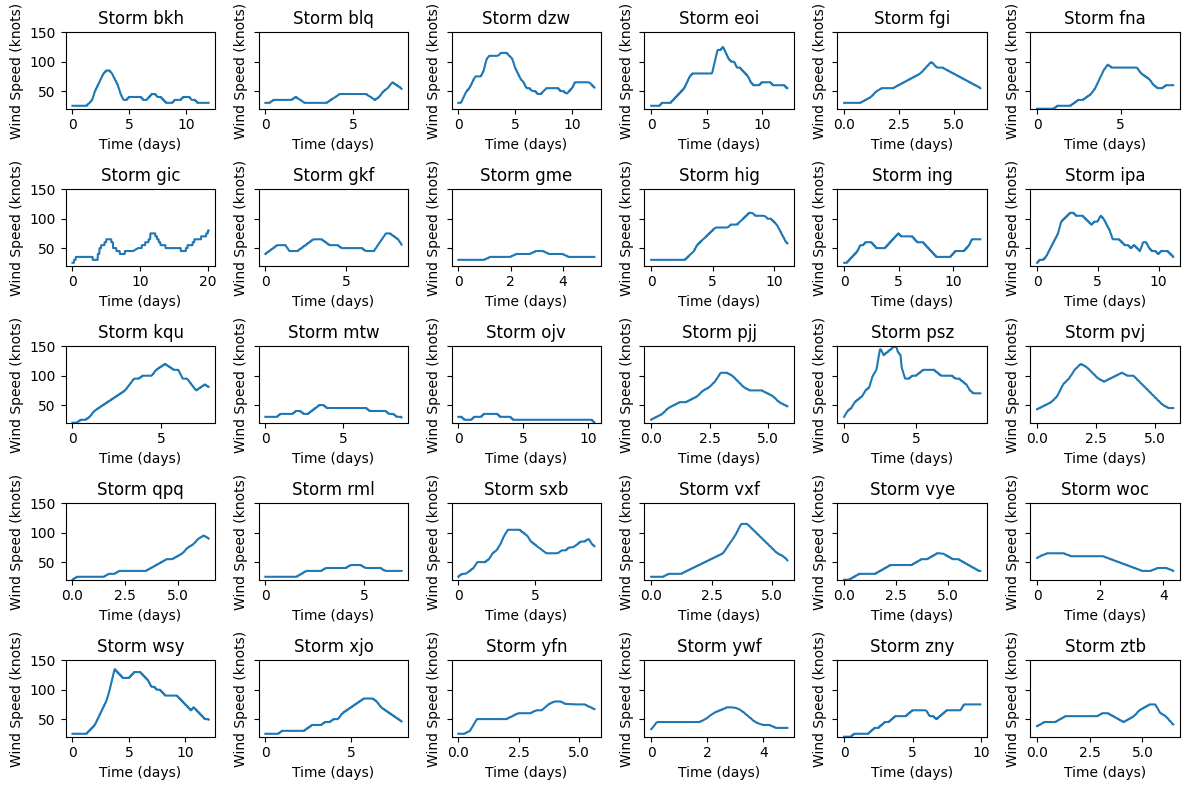

In [68]:
# here we can look at the progression of windspeeds over time for all of the storms
exp.wind_speed_plots(data_df)

#### We can see here that the windspeed ranges vary greatly from storm to storm, and that there are similarities but no consistent pattern across storms. This means that the best strategy would be to retain the model on each storm individually, before predicting windspeed values for that storm. This is how we decided to go for a model that trains on only one storm instead of all of them at the same time. Weather patterns can also be unpredictable, so it may make sense from this perspective to confine our training to the nuance of a single storm. 

# The Model

In the initial phase of the mdoel development process, our Task 2 sub-team went off and created models individually to facilitate as many ideas as possible. We then reconvened, compared and decided on a course of action. The models that were individually created were as follows:

- A. a custom ResNet with time embedding that attempted to take raw data and output the predicted windspeed (>40 RMSE)
- B. feature extraction using a CNN, an LSTM to extract time and an encoder to encode the storm id and ocean id. These features were then inputted into a linear regression to predict windspeed (<5 RMSE)
- C. feature extraction using a CNN and an LSTM to extract time. These features were inputted into a fully connected network to generate predictions (5-10 RMSE) 


Because model B had the best RMSE, we chose to hypertune it, especially with respect learning rate, number of epochs and batch size.  

In [2]:
# import functions from the windspeed prediction package
from speed import load_json_data, load_img_data, df_transformer, init_dataset, HybridNN, train_val

In [13]:
# create a dataframe of the data and a file name dictionary
json_df, file_name_dict = load_json_data('./data/')

In [5]:
# using a label encoder to transform the storm_id feature
json_df, label_encoder = df_transformer(json_df)

In [6]:
img_file = load_img_data(file_name_dict, folder_path='./data/')

In [11]:
dataset = init_dataset(img_file, json_df)

In [150]:
json_df

,relative_time,ocean,wind_speed,id
0,0.0,1.0,25.0,0.0
1,1801.0,1.0,25.0,0.0
2,3600.0,1.0,25.0,0.0
3,5400.0,1.0,25.0,0.0
4,7200.0,1.0,25.0,0.0
...,...,...,...,...
405,1022400.0,1.0,30.0,0.0
406,1026001.0,1.0,30.0,0.0
407,1027801.0,1.0,30.0,0.0
408,1029601.0,1.0,30.0,0.0


### Training model on storm 'bkh'

In [12]:
from torch.utils.data import DataLoader, random_split
val_size = 10
train_size = len(dataset) - 10
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# for generating all windspeed predictions
final_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

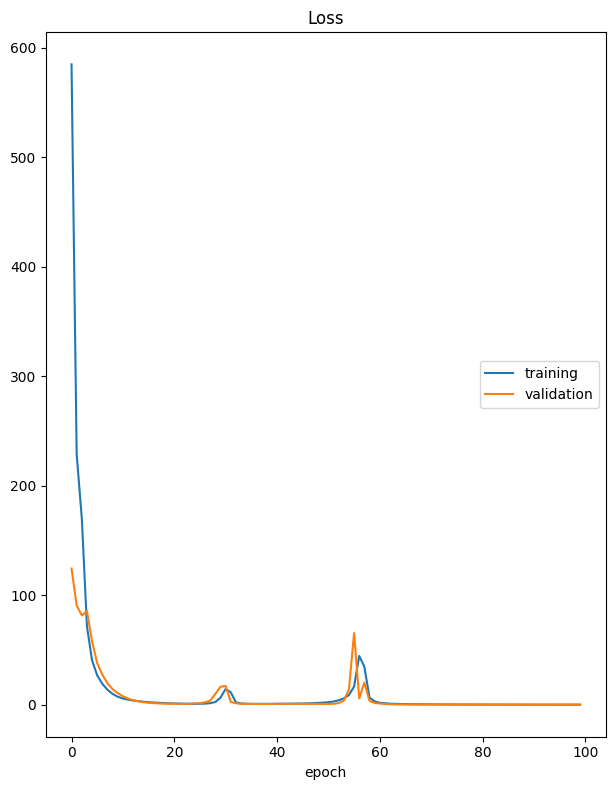

Loss
	training         	 (min:    0.089, max:  584.873, cur:    0.089)
	validation       	 (min:    0.168, max:  124.441, cur:    0.169)


In [152]:
model = HybridNN()
train_val(model, train_loader, val_loader, lr=0.0005)

In [153]:
# saving the model so we dont accidentally lose all of the training
save_path = 'bkh_model_state_dict.pth'
torch.save(model.state_dict(), save_path)

## Load model

In [13]:
model = HybridNN()
state_dict_path = 'bkh_model_state_dict.pth'
loaded_state_dict = torch.load(state_dict_path)
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

## Generating Predictions with the Model for Storm 'bhk'

In [16]:
model.eval()
criterion = nn.MSELoss()
total_val_loss = 0
predictions, actuals = [], []
exp = []
act = []
with torch.no_grad():
    for batch in val_loader:
        x_img, x_storm_id, x_relative_time, x_ocean, y = batch
        x_relative_time = x_relative_time.unsqueeze(2)

        outputs = model(x_img, x_storm_id, x_relative_time, x_ocean)
        exp.append(y)
        act.append(outputs)

        print("-------------------------------------------- \
                --------------------------")
        exp_floats = ['{:.2f}'.format(x.item()) for x in y]
        print("GroundTruth:", exp_floats)
        act_floats = ['{:.2f}'.format(x.item()) for x in outputs]
        print("Prediction: ", act_floats)
        print("-------------------------------------------- \
                --------------------------")
        loss = criterion(outputs, y)
        total_val_loss += loss.item()
        predictions.extend(outputs.squeeze(1).tolist())
        actuals.extend(y.squeeze(1).tolist())
print(f'MSEloss = {loss}')
        


--------------------------------------------                 --------------------------
GroundTruth: ['71.00', '79.00', '38.00', '85.00', '35.00', '62.00', '31.00', '30.00', '44.00', '35.00']
Prediction:  ['70.65', '78.51', '37.78', '84.50', '34.85', '61.52', '30.54', '29.65', '43.42', '34.80']
--------------------------------------------                 --------------------------
MSEloss = 0.16351066529750824


We chose to train the model using MSE loss, because we are predicting a continuous integer, and we wanted to penalize large deviations.

### Plotting the Ground Truth against the Predictions for storm 'bkh'

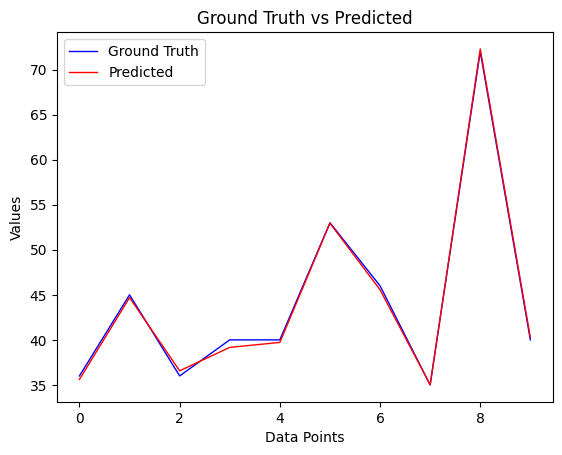

In [155]:
plt.plot(actuals, linestyle='-', color='blue', linewidth=1, label='Ground Truth')
plt.plot(predictions, linestyle='-', color='red', linewidth=1, label='Predicted')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Ground Truth vs Predicted')
plt.legend()

# for validation set only
plt.show()

In [156]:
# Display mean and std
differences = np.array(predictions) - np.array(actuals)
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)  

confidence_level = 0.95
lower_bound, upper_bound = stats.t.interval(confidence_level, len(differences) - 1,
                                            loc=mean_diff, scale=std_diff)

print(f'Mean Difference: {mean_diff:.4f}')
print(f'Standard Deviation of Differences: {std_diff:.4f}')
print(f'Confidence Interval ({confidence_level * 100}%): ({lower_bound:.4f}, {upper_bound:.4f})')

Mean Difference: -0.1159
Standard Deviation of Differences: 0.4162
Confidence Interval (95.0%): (-1.0573, 0.8255)


The confidence interval provides a range within which we can reasonably expect the true mean difference to fall. In this case, with 95% confidence, the true mean difference between predicted and actual values is estimated to be within the range of approximately -1.0573 to 0.8255.

### Just to assure ourselves that the model architecture works on a different distribution of windspeed to that of 'bkh', we will train the model again on a storm that has a very different range and shape of windspeed curve.

** Note that the livelossplot was cut from the package between the training of each model, hence the difference in each of the outputs. Tweaks were made to the package but model architecture remained unchanged.

In [3]:
# following the workflow above
json_df, file_name_dict = load_json_data('./data/')
json_df, label_encoder = df_transformer(json_df)
img_file = load_img_data(file_name_dict, folder_path='./data/')
dataset = init_dataset(img_file, json_df)

psz


In [12]:
from torch.utils.data import DataLoader, random_split
val_size = 10
train_size = len(dataset) - 10
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
# for generating all windspeed predictions
final_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [13]:
model = HybridNN()
train_val(model, train_loader, val_loader, lr=0.000883, num_epochs=500)

Epoch 1/500, Training Loss:                9624.8558
--------------------------------------------                       --------------------------
GroundTruth: ['68.00', '100.00', '100.00', '104.00', '109.00', '43.00', '95.00', '104.00', '114.00', '100.00']
Prediction:  ['12.56', '12.06', '12.18', '12.50', '12.30', '12.45', '12.34', '12.27', '12.38', '12.36']
--------------------------------------------                       --------------------------
Validation Loss: 7042.9712, MSE: 7042.9710
Epoch 2/500, Training Loss:                6340.4261
--------------------------------------------                       --------------------------
GroundTruth: ['68.00', '100.00', '100.00', '104.00', '109.00', '43.00', '95.00', '104.00', '114.00', '100.00']
Prediction:  ['55.43', '52.37', '53.26', '55.82', '54.18', '54.67', '54.04', '54.44', '55.27', '54.95']
--------------------------------------------                       --------------------------
Validation Loss: 1968.6238, MSE: 1968.6237
Ep

In [14]:
save_path = 'psz_model_state_dict.pth'
torch.save(model.state_dict(), save_path)

In [15]:
model.eval()
criterion = nn.MSELoss()
total_val_loss = 0
predictions, actuals = [], []
exp = []
act = []
with torch.no_grad():
    for batch in val_loader:
        x_img, x_storm_id , x_relative_time, x_ocean_id, y = batch
        x_relative_time = x_relative_time.unsqueeze(2)

        outputs = model(x_img,x_relative_time)
        exp.append(y)
        act.append(outputs)

        print("-------------------------------------------- \
                --------------------------")
        exp_floats = ['{:.2f}'.format(x.item()) for x in y]
        print("GroundTruth:", exp_floats)
        act_floats = ['{:.2f}'.format(x.item()) for x in outputs]
        print("Prediction: ", act_floats)
        print("-------------------------------------------- \
                --------------------------")
        loss = criterion(outputs, y)
        total_val_loss += loss.item()
        predictions.extend(outputs.squeeze(1).tolist())
        actuals.extend(y.squeeze(1).tolist())
print(f'MSEloss = {loss}')
        


--------------------------------------------                 --------------------------
GroundTruth: ['68.00', '100.00', '100.00', '104.00', '109.00', '43.00', '95.00', '104.00', '114.00', '100.00']
Prediction:  ['68.53', '99.61', '99.93', '103.39', '106.84', '42.70', '98.26', '106.44', '113.61', '101.40']
--------------------------------------------                 --------------------------
MSEloss = 2.427260398864746


### Plotting the ground truth against predictions for storm 'psz'

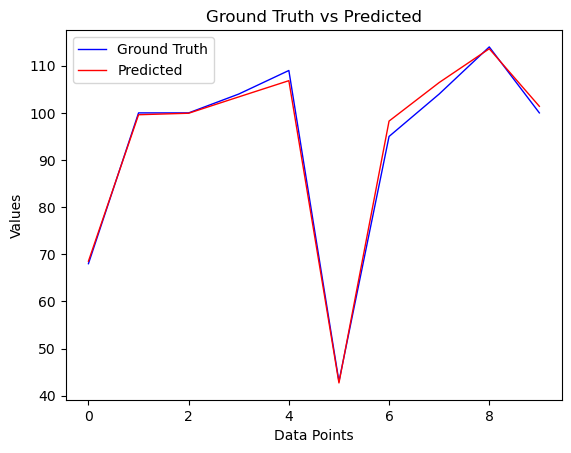

In [16]:
plt.plot(actuals, linestyle='-', color='blue', linewidth=1, label='Ground Truth')
plt.plot(predictions, linestyle='-', color='red', linewidth=1, label='Predicted')

plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Ground Truth vs Predicted')
plt.legend()

# for validation set only
plt.show()

Here we can see that the model architecture also performs reasonably well on a storm with a different windspeed range and shape curve, which instills confidence that it is a generisable architecture and will perform on the surprise storm.